<a href="https://colab.research.google.com/github/jina-ai/pqlite/blob/feat-colab-notebook/notebooks/fashion_product_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PQLite Tutorial

<div align="left">
<a href="https://github.com/jina-ai/pqlite/blob/feat-colab-notebook/notebooks/fashion_product_search.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/jina-ai/pqlite/blob/feat-colab-notebook/notebooks/fashion_product_search.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Building a Neural Search System for Ecommerce Product Search

In this tutorial, we will build a neural search engine for images of [Fasion Product Image (Small)](https://www.kaggle.com/paramaggarwal/fashion-product-images-small).

![image](https://storage.googleapis.com/kaggle-datasets-images/175990/396802/720cd7ceb25eb130d0b873464f734370/data-original.png?t=2019-04-26-16-40-29)

## Problem definition

We want to search Fashion Product by Image


---

## Preliminaries

**Note**: *Skip this if you've already downloaded them.*


**Download dataset**

In [1]:
!rm -rf data
!pip install gdown
!gdown https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
!unzip fashion.zip -d data > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
To: /content/fashion.zip
100% 593M/593M [00:03<00:00, 149MB/s]


**Install dependencies**

In [ ]:
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install torchvision

!pip install jina==2.5.4
!pip install pqlite==0.1.0

**Clear workspace**

In [39]:
!rm -rf workspace
!mkdir workspace

---

# ResNet50 Image Search


In [75]:
import os
import glob

import pandas as pd

from PIL import Image
from jina import Document, DocumentArray

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from pqlite import PQLite

os.environ['JINA_LOG_LEVEL'] = 'DEBUG'

**Prepare Data**

In [40]:
MAX_NUM_DOCS = 200

df = pd.read_csv('/content/data/styles.csv', warn_bad_lines=True, error_bad_lines=False)
df = df.dropna()
df['year'] = df['year'].astype(int)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [60]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [66]:
def get_product_docs(max_num: int = MAX_NUM_DOCS):
    da = DocumentArray()
    for index, row in df.iterrows():
        doc_id = row.pop('id')
        doc_uri = f'/content/data/myntradataset/images/{doc_id}.jpg'

        doc = Document(id=doc_id, uri=doc_uri, tags=dict(row))
        da.append(doc)
        if len(da) == max_num:
            break
    
    return da

In [123]:
docs = get_product_docs(500)
print(len(docs)) # should be 200

500


**Preprocess documents**



In [124]:
def preproc(d: Document):
    return (d.load_uri_to_image_blob()  # load
             .set_image_blob_normalization()  # normalize color 
             .set_image_blob_channel_axis(-1, 0))  # switch color axis
docs.apply(preproc)

<jina.types.arrays.document.DocumentArray (length=500) at 139500895621968>

**Encode image documents**

In [125]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
docs.embed(model, device='cpu', to_numpy=True)

<jina.types.arrays.document.DocumentArray (length=500) at 139500895621968>

**Index documents into PQLite**

In [126]:
# clear the index data first
!rm -rf workspace/*

index = PQLite(dim=1000, 
               metric='cosine', 
               columns=[
                        ('year', int), 
                        ('baseColour', str), 
                        ('masterCategory', str)
                ], 
               data_path='./workspace')
index.index(docs)

2021-12-14 07:45:43.640 | DEBUG    | pqlite.container:insert:203 - => 500 new docs added


In [146]:
befor_year = "2019" #@param [2017, 2018, 2019]
category = "Apparel" #@param ["Apparel", "Footwear"]
color = "Brown" #@param ["White", "Black", "Brown"]



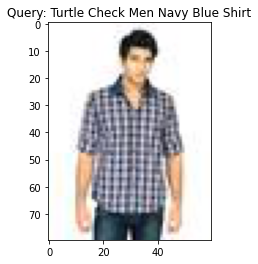

[0] (0.22626632452011108) category: Apparel year: 2011


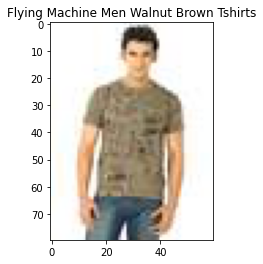

[1] (0.28413403034210205) category: Apparel year: 2011


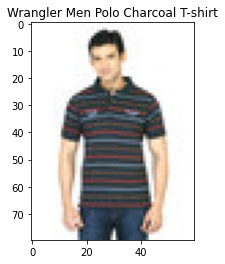

[2] (0.3866616487503052) category: Apparel year: 2012


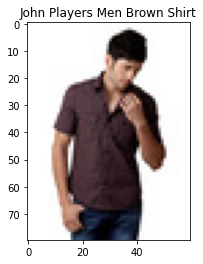

[3] (0.4075077176094055) category: Apparel year: 2012


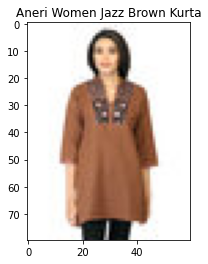

[4] (0.42396092414855957) category: Apparel year: 2012


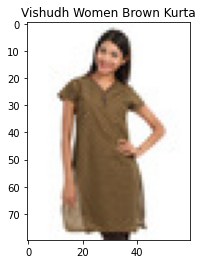

In [147]:
query = docs[:1]
index.search(query, 
             filter={
                 'year': {'$lte': year}, 
                 'masterCategory': {'$eq': category},
                 'baseColour': {'$eq': color}
                }, 
             limit=5, 
             include_metadata=True)


img = Image.open(query[0].uri)
imshow(img)
plt.title(f'Query: {query[0].tags["productDisplayName"]}')
plt.show()
for doc in query:
    for k, match in enumerate(doc.matches):
        print(f'[{k}] ({match.scores["cosine"].value}) category: {match.tags["masterCategory"]} year: {int(match.tags["year"])}')
        img = Image.open(match.uri)
        imshow(img)
        plt.title(f'{match.tags["productDisplayName"]}')
        plt.show()

## 6. Flow-As-A-Service & Deploy 

In [ ]:
from jina import Flow 

f = Flow(protocol='grpc', port_expose=123456).add().add() ## grpc, websocket, http
with f:
    f.block()

      executor0@2387[D]:setting up sockets...
⠋ 0/3 waiting executor0 executor1 gateway to be ready...      executor0@2387[D]:control over tcp://0.0.0.0:55961
      executor0@2387[D]:input 0.0.0.0:47315
      executor0@2387[D]:input tcp://0.0.0.0:47315 (ROUTER_BIND) output tcp://0.0.0.0:33219 (ROUTER_BIND) control over tcp://0.0.0.0:55961 (PAIR_BIND)
        gateway@2389[D]:setting up sockets...
      executor1@2388[D]:setting up sockets...
      executor1@2388[D]:control over tcp://0.0.0.0:60135
        gateway@2389[D]:control over ipc:///tmp/tmpt37ilwuz
      executor1@2388[D]:input 0.0.0.0:51737
      executor1@2388[D]:input tcp://0.0.0.0:51737 (ROUTER_BIND) output tcp://0.0.0.0:49513 (ROUTER_BIND) control over tcp://0.0.0.0:60135 (PAIR_BIND)
        gateway@2389[D]:input 0.0.0.0:35479
        gateway@2389[D]:input tcp://0.0.0.0:35479 (ROUTER_BIND) output tcp://0.0.0.0:50923 (ROUTER_BIND) control over ipc:///tmp/tmpt37ilwuz (PAIR_BIND)
⠙ 0/3 waiting executor0 executor1 gateway to be

In [ ]:
f = Flow(infrastructure='k8s').add(name='k8s_executor1', replicas=2).add(name='k8s_executor2', replicas=3)
f.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGs4c19leGVjdXRvcjE7CgpkaXJlY3Rpb24gTFI7CgprOHNfZXhlY3V0b3IxL3JlcGxpY2EtMFtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IxL3JlcGxpY2EtMVtCYXNlRXhlY3V0b3JdOwplbmQ7CnN1YmdyYXBoIGs4c19leGVjdXRvcjI7CgpkaXJlY3Rpb24gTFI7CgprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMFtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMVtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMltCYXNlRXhlY3V0b3JdOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IGs4c19leGVjdXRvcjE6OjpQT0Q7Cms4c19leGVjdXRvcjE6OjpQT0QgLS0+IGs4c19leGVjdXRvcj

More on the deployment, please check [this](https://github.com/jina-ai/jina#deploy-to-kubernetes-in-7-minutes-) link, and we complete our pipeline

![pipeline](https://github.com/jina-ai/jina/raw/master/.github/images/readme-get-started.svg?raw=true)